<Axes: >

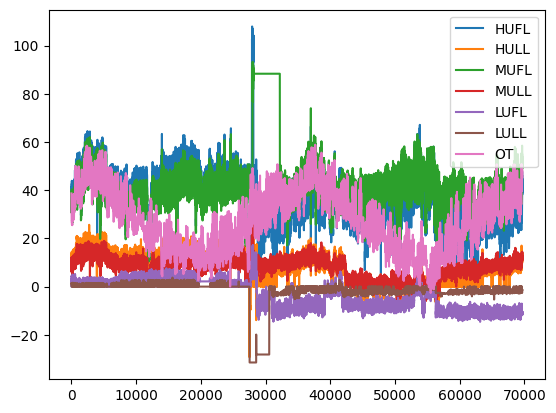

In [2]:
import pandas as pd 

df = pd.read_csv("ETTm2.csv")
df.plot()

In [3]:
df['date'] = pd.to_datetime(df['date'])
training_df = df[df['date'] < df['date'].min() + pd.DateOffset(months=12)]
val_df = df[df['date'] > df['date'].min() + pd.DateOffset(months=12)][df['date'] < df['date'].min() + pd.DateOffset(months=16)]
test_df = df[df['date'] > df['date'].min() + pd.DateOffset(months=16)][df['date'] < df['date'].min() + pd.DateOffset(months=20)]

/tmp/ipykernel_2453/2599488179.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  val_df = df[df['date'] > df['date'].min() + pd.DateOffset(months=12)][df['date'] < df['date'].min() + pd.DateOffset(months=16)]
/tmp/ipykernel_2453/2599488179.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  test_df = df[df['date'] > df['date'].min() + pd.DateOffset(months=16)][df['date'] < df['date'].min() + pd.DateOffset(months=20)]


In [4]:
import torch
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

class TimeSeriesDataset(Dataset):
    def __init__(self,df, target_column,drop_cols,future_steps, p_lag=0):
        self.df = df.drop(drop_cols, axis=1)
        self.p_lag = p_lag
        self.len_df_minus_lag = len(self.df) - p_lag - future_steps
        self.target_column = target_column
        self.future_steps = future_steps
        
    def __len__(self):
        return self.len_df_minus_lag

    def __getitem__(self, idx):
        input_p_lag = torch.tensor(self.df.iloc[(idx):(idx + self.p_lag),:].astype(float).to_numpy().transpose().reshape(1,-1), requires_grad=True)
        target = torch.tensor(self.df[self.target_column].iloc[(idx + self.p_lag): (idx + self.p_lag + self.future_steps),:].astype(float).to_numpy()).reshape(1,-1)
        return input_p_lag, target

In [5]:
import math
import torch.nn as nn

class DecompositionLayer(nn.Module):
    def __init__(self, kernel_size):
        super().__init__()
        self.kernel_size = kernel_size
        self.avg = nn.AvgPool1d(kernel_size=kernel_size, stride=1, padding=0) 

    def forward(self, x):
        #print(x.shape)
        num_of_pads = (self.kernel_size - 1) // 2
        #print(num_of_pads)
        if self.kernel_size > 7: 
            front = x[:, 0:1, :].repeat(1, num_of_pads + 1, 1)
        else: 
            front = x[:, 0:1, :].repeat(1, num_of_pads, 1)
        end = x[:, -1:, :].repeat(1, num_of_pads, 1)
        x_padded = torch.cat([front, x, end], dim=1)
        #print(x_padded.shape)

        x_trend = self.avg(x_padded.permute(0, 2, 1)).permute(0, 2, 1)
        
        #print(x_trend.shape) # why do i loose one value if i increase decomp-size above 7
        x_seasonal = x - x_trend
        return x_seasonal, x_trend

class ARNet(nn.Module):
    def __init__(self, p_lag, n_features, future_steps, decomp_kernel_size = 7):
        super(ARNet, self).__init__()
        self.input_trend_layer = nn.Linear(p_lag * n_features, math.ceil(p_lag * n_features/1.5))
        self.output_trend_layer = nn.Linear(math.ceil(p_lag * n_features/1.5), future_steps)
        self.input_seasonal_layer = nn.Linear(p_lag * n_features, math.ceil(p_lag * n_features/2))
        self.output_seasonal_layer = nn.Linear(math.ceil(p_lag * n_features/2), future_steps)
        self.decomp_layer = DecompositionLayer(decomp_kernel_size)
        self.criterion = nn.MSELoss()
        self.p_lag = p_lag

    def forward(self, input):
        input = input.float()
        input_season, input_trend = self.decomp_layer(input.reshape(1,self.p_lag, 7))
        x_season = self.input_seasonal_layer(input_season.reshape(1, self.p_lag*7))
        y_hat_season = self.output_seasonal_layer(x_season)
        x_trend = self.input_trend_layer(input_trend.reshape(1, self.p_lag*7))
        y_hat_trend = self.output_trend_layer(x_trend)

        return y_hat_season + y_hat_trend

In [1]:
from torchmetrics.regression import MeanAbsolutePercentageError

def train(epochs, p_lag, future_steps, training_df, validation_df, drop_cols = 'date', target_column = ['OT'], learning_rate=1.e-4, decomp_kernel_size= 7): 
    net = ARNet(p_lag=p_lag, n_features=7, future_steps=future_steps, decomp_kernel_size=decomp_kernel_size)

    train_data = DataLoader(TimeSeriesDataset(training_df, future_steps= future_steps, target_column = target_column,drop_cols=drop_cols,p_lag=p_lag))
    train_loss_list = []
    val_data = DataLoader(TimeSeriesDataset(validation_df,future_steps= future_steps, target_column = target_column,drop_cols=drop_cols,p_lag=p_lag))
    val_loss_list = []

    mae = nn.L1Loss()
    mape = MeanAbsolutePercentageError()

    torch.set_grad_enabled(True)
    optimizer = torch.optim.Adam(net.parameters(), lr=learning_rate)
    running_train_loss = 0.
    running_val_loss = 0.
    
    running_val_mae = 0.
    running_train_mae = 0.

    running_val_mape = 0.
    running_train_mape = 0.

    train_counter = 1
    val_counter = 1
    for epoch in range(epochs): 
        if epoch + 1 != 1: 
            learning_rate = learning_rate / 2
            optimizer = torch.optim.Adam(net.parameters(), lr=learning_rate)
        print(f"Current learning rate is : {learning_rate}")  
        print("---------------------------")
        for i, data in enumerate(train_data):
            inputs, labels = data
            labels = labels.squeeze(0).float()
            optimizer.zero_grad()
            outputs = net(inputs)
            #outputs = outputs.squeeze(0)
            loss = net.criterion(outputs, labels)
            loss.backward()
            torch.nn.utils.clip_grad_norm_(net.parameters(), 1)
            optimizer.step()
            running_train_loss += loss.item()

            mae_score = mae(outputs, labels)
            running_train_mae += mae_score.item()
            
            mape_score = mape(outputs, labels)
            running_train_mape += mape_score.item()

            train_counter += 1
            if train_counter % 10000 == 0: 
                print(f"Current (running) training loss at iteration {train_counter} : {running_train_loss/train_counter}")

        train_loss_list.append(running_train_loss/train_counter)
            
        for i, data in enumerate(val_data):
            inputs, test_labels = data
            test_labels = test_labels.squeeze(0).float()
            output = net(inputs)
            #output = output.squeeze(0)
            val_loss = net.criterion(output, test_labels)
            mae_score = mae(output, test_labels)
            mape_score = mape(output, test_labels)

            running_val_loss += val_loss.item()
            running_val_mae += mae_score.item()
            running_val_mape += mape_score.item()

            val_counter += 1
        val_loss_list.append(running_val_loss/val_counter)


        if epoch % 1 == 0: 
            print(f"Epoch {epoch}: ")
            print(f"Running (training) MSE is {running_train_loss/train_counter}.")
            print(f"Training MAE is {running_train_mae/train_counter}.")
            print(f"Training MAPE is {running_train_mape/train_counter}.")

            print(f"Test MSE is {running_val_loss/val_counter}.")
            print(f"Test MAE is {running_val_mae/val_counter}.")
            print(f"Test MAPE is {running_val_mape/val_counter}.")
            print("---------------------------")
    
    return net

In [41]:
p_lag = 72
future_steps = 1

net = train(epochs = 5, p_lag=  p_lag, future_steps = future_steps, training_df = training_df, validation_df = val_df, target_column = ['OT'], drop_cols='date', learning_rate=1.e-4 ,decomp_kernel_size= 24)

test_data = DataLoader(TimeSeriesDataset(val_df,future_steps= future_steps, target_column = ['OT'],drop_cols='date',p_lag=p_lag))

for i, data in enumerate(test_data):
    inputs, labels = data
    output = net(inputs)
    print(f"predicted output is {output.squeeze(0,1).tolist()} and true value is {labels.squeeze(0,1).tolist()}")
    if i > 1: 
        break

Current learning rate is : 0.0001
---------------------------
Current (running) training loss at iteration 10000 : 11.506921743572947
Current (running) training loss at iteration 20000 : 8.51339746772096
Current (running) training loss at iteration 30000 : 8.324047436463523
Epoch 0: 
Running (training) MSE is 8.372680023684925.
Training MAE is 1.8933053472322448.
Training MAPE is 324.0546908270748.
Test MSE is 142.16536064029077.
Test MAE is 9.78947552289666.
Test MAPE is 0.307006294970921.
---------------------------
Current learning rate is : 5e-05
---------------------------
Current (running) training loss at iteration 40000 : 7.944244935790469
Current (running) training loss at iteration 50000 : 7.330984880807791
Current (running) training loss at iteration 60000 : 6.699299513554468
Epoch 1: 
Running (training) MSE is 6.354706965262346.
Training MAE is 1.6259942965092615.
Training MAPE is 358.24932329263646.
Test MSE is 112.24136186144062.
Test MAE is 8.333899743099115.
Test MAPE i

In [28]:
#prediction for 100 steps in the case of only univariate time series
steps = 100
for i, data in enumerate(test_data): 
    input, _ = data
    prediction = net(input)
    new_input = torch.cat([input.squeeze(0).squeeze(0)[1:], prediction.squeeze(0)])
    for _ in range(steps): 
        prediction = net(new_input)
        new_input = torch.cat([new_input.squeeze(0).squeeze(0)[1:], prediction.squeeze(0)])   
    new_input

KeyboardInterrupt: 

In [42]:
#iterative prediction for 100 steps in the case of only multivariate time series
# we assume full knowledge of covariates at each time 
steps = 1000
prediction_list = []
target_list = []
for i, data in enumerate(test_data): 
    input, target = data
    prediction = net(input)
    prediction_list.append(prediction.squeeze(0).item())
    target_list.append(target.squeeze(0).item())
    if i == (steps -1): 
        break
    new_input

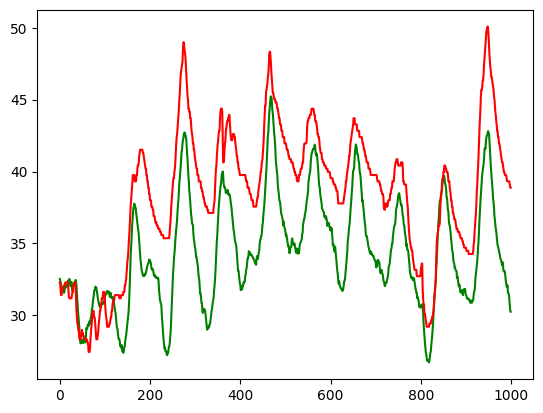

In [43]:
import matplotlib.pyplot as plt
plt.plot(prediction_list, 'g', target_list, 'r')
plt.show()